In [59]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from tqdm import tqdm
from merge_bond_treasury_redcode import *
import ctypes
from scipy.interpolate import CubicSpline
from merge_cds_bond import *

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
path1 = "../_data/issue_data.parquet"
path2 = "../_data/monthly_ts_data.parquet"

wrds_path = "../../FS-project-files/wrds_bond.parquet"
red_code_path = "../../FS-project-files/RED_and_ISIN_mapping.parquet"
cds_path = "../../FS-project-files/cds_final.pkl"
fin_path = "../../FS-project-files/merged_bond_treas_red.pkl"

issue_df = pd.read_parquet(path1)
treas_df = pd.read_parquet(path2)
bond_df = pd.read_parquet(wrds_path)
red_df = pd.read_parquet(red_code_path)

fin_df = pd.read_pickle(fin_path)
cds_df = pd.read_pickle(cds_path)

In [60]:
df10 = merge_cds_into_bonds(fin_df, cds_df)

c:\Users\xuv14\Winter 2025 FINM\Full Stack\full_stack_project\src\merge_cds_bond.py:138: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  par_df = par_df.applymap(safe_convert)


In [61]:
df10

,cusip,date,maturity,yield,rating,treas_yld,par_spread,t_spread,price_eom,amount_outstanding
0,001957AM1,2002-07-31,2004-04-01,0.085600,1,0.020340,0.069154,0.014847,97.213129,400000.0
4,001957AM1,2002-09-30,2004-04-01,0.066960,1,0.015797,0.046843,0.007308,100.066504,400000.0
6,001957AM1,2002-10-31,2004-04-01,0.066670,0,0.014777,0.039719,0.007682,100.112053,400000.0
10,001957AM1,2002-12-31,2004-04-01,0.036044,0,0.012791,0.022669,0.010935,103.810897,123856.0
12,001957AM1,2003-01-31,2004-04-01,0.036545,0,0.013383,0.024194,0.010090,103.500000,123856.0
...,...,...,...,...,...,...,...,...,...,...
557259,110122DZ8,2023-11-30,2033-11-15,0.052103,0,0.043705,0.006427,0.001606,105.310818,1000000.0
557264,133131BA9,2023-11-30,2026-11-03,0.052437,0,0.044739,0.000829,0.000603,101.627580,500000.0
557269,63743HFK3,2023-11-30,2026-11-13,0.050558,0,0.044795,0.001156,0.002571,101.479897,400000.0
557307,883203CD1,2023-11-30,2033-11-15,0.056958,0,0.043705,0.017182,0.001592,103.045046,350000.0


In [3]:
cds_df.head()

,date,ticker,redcode,parspread,tenor,tier,country,year
0,2002-01-01,T,001AEC,0.017589,10Y,SNRFOR,United States,2002
1,2002-01-01,T,001AEC,0.016295,10Y,SNRFOR,United States,2002
2,2002-01-01,T,001AEC,0.015566,10Y,SNRFOR,United States,2002
3,2002-01-01,T,001AEC,0.013413,1Y,SNRFOR,United States,2002
4,2002-01-01,T,001AEC,0.012417,1Y,SNRFOR,United States,2002


In [57]:
cds_df.columns

Index(['date', 'ticker', 'redcode', 'parspread', 'tenor', 'tier', 'country',
       'year'],
      dtype='object')

In [6]:
cds_df.dropna(subset=['date', 'parspread', 'tenor', 'redcode']).shape

(52227940, 8)

In [ ]:
cds_df.shape

(52324311, 8)

In [8]:
date_set = set(fin_df.date.unique())

In [9]:
c_df = cds_df.copy()
f_df = fin_df.copy()

c_df = c_df[c_df['date'].isin(date_set)].dropna(subset=['date', 'parspread', 'tenor', 'redcode'])

In [10]:
c_df_avg = c_df.groupby(c_df.columns.difference(['parspread']).tolist(), as_index=False).agg({'parspread': 'median'})

In [11]:
c_df_avg['parspread'].describe()

count    419554.000000
mean          0.018084
std           0.059668
min           0.000020
25%           0.003591
50%           0.007709
75%           0.016946
max           6.818997
Name: parspread, dtype: float64

In [12]:
df_unique_count = c_df_avg.groupby(['redcode', 'date'])['tenor'].nunique().reset_index()

# Rename column for clarity
df_unique_count.rename(columns={'tenor': 'unique_tenor_count'}, inplace=True)

df_unique_count = df_unique_count[df_unique_count['unique_tenor_count'] > 1]

filtered_df = c_df_avg.merge(df_unique_count[['redcode', 'date']], on=['redcode', 'date'], how='inner')


In [13]:
# Mapping tenor to days
tenor_to_days = {
    "1Y": 365,
    "3Y": 3 * 365,
    "5Y": 5 * 365,
    "7Y": 7 * 365,
    "10Y": 10 * 365
}

# Convert tenor to days
filtered_df['tenor_days'] = filtered_df['tenor'].map(tenor_to_days)

# Dictionary to store cubic splines for each (redcode, date) pair
cubic_splines = {}

# Group by (redcode, date) and create splines
for (redcode, date), group in filtered_df.groupby(['redcode', 'date']):
    x = group['tenor_days'].values  # Tenor in days (independent variable)
    y = group['parspread'].values   # Par spread (dependent variable)
    
    # Ensure data is sorted by tenor days before fitting spline
    sorted_indices = np.argsort(x)
    x_sorted, y_sorted = x[sorted_indices], y[sorted_indices]

    # Fit cubic spline
    try:
        cubic_splines[(redcode, date)] = CubicSpline(x_sorted, y_sorted)
    except:
        print(x_sorted)
        print(y_sorted)

In [20]:
f_df.shape

(557455, 12)

In [22]:
red_set = set(filtered_df['redcode'].unique())

f_df = f_df[f_df['redcode'].isin(red_set)]

In [25]:
f_df['days'] = (f_df['maturity'] - f_df['date']).dt.days

In [30]:
def add_par_spread_vectorized(f_df):
    # Create a mask for existing (redcode, date) pairs in cubic_splines
    mask = f_df.set_index(['redcode', 'date']).index.isin(cubic_splines.keys())

    # Apply spline interpolation only for matching keys
    valid_rows = f_df.loc[mask]
    f_df.loc[mask, 'par_spread'] = valid_rows.apply(
        lambda row: cubic_splines[(row['redcode'], row['date'])](row['days']), axis=1
    )

    # Fill non-matching rows with NaN
    f_df['par_spread'] = f_df['par_spread'].fillna(np.nan)
    
    return f_df

In [31]:
par_df = add_par_spread_vectorized(f_df)

In [33]:
par_df = par_df.dropna(subset=['par_spread'])

# Probably add another function here 

In [34]:
par_df.head()

,cusip,company_symbol,date,maturity,amount_outstanding,yield,rating,price_eom,t_spread,treas_yld,issuer_cusip,redcode,days,par_spread_interpolated,par_spread
0,001957AM1,T,2002-07-31,2004-04-01,400000.0,0.085600,1,97.213129,0.014847,0.020340,001957,001AEC,610,0.06915381590725042,0.06915381590725042
4,001957AM1,T,2002-09-30,2004-04-01,400000.0,0.066960,1,100.066504,0.007308,0.015797,001957,001AEC,549,0.04684339997240904,0.04684339997240904
6,001957AM1,T,2002-10-31,2004-04-01,400000.0,0.066670,0,100.112053,0.007682,0.014777,001957,001AEC,518,0.03971921799722878,0.03971921799722878
10,001957AM1,T,2002-12-31,2004-04-01,123856.0,0.036044,0,103.810897,0.010935,0.012791,001957,001AEC,457,0.022668570693580196,0.022668570693580196
12,001957AM1,T,2003-01-31,2004-04-01,123856.0,0.036545,0,103.500000,0.010090,0.013383,001957,001AEC,426,0.024193934800591666,0.024193934800591666


In [35]:
man_df = par_df[['cusip', 'date', 'maturity', 'yield', 'rating', 'treas_yld', 'par_spread']]

man_df

,cusip,date,maturity,yield,rating,treas_yld,par_spread
0,001957AM1,2002-07-31,2004-04-01,0.085600,1,0.020340,0.06915381590725042
4,001957AM1,2002-09-30,2004-04-01,0.066960,1,0.015797,0.04684339997240904
6,001957AM1,2002-10-31,2004-04-01,0.066670,0,0.014777,0.03971921799722878
10,001957AM1,2002-12-31,2004-04-01,0.036044,0,0.012791,0.022668570693580196
12,001957AM1,2003-01-31,2004-04-01,0.036545,0,0.013383,0.024193934800591666
...,...,...,...,...,...,...,...
557259,110122DZ8,2023-11-30,2033-11-15,0.052103,0,0.043705,0.006426885731044571
557264,133131BA9,2023-11-30,2026-11-03,0.052437,0,0.044739,0.0008289399235831619
557269,63743HFK3,2023-11-30,2026-11-13,0.050558,0,0.044795,0.001155872907852163
557307,883203CD1,2023-11-30,2033-11-15,0.056958,0,0.043705,0.017181684693239697


In [43]:
def safe_convert(x):
    """Convert lists and arrays to tuples while keeping other data types unchanged."""
    if isinstance(x, list):
        return tuple(x)
    elif isinstance(x, np.ndarray):
        return tuple(x.tolist()) if x.ndim > 0 else x.item()  # Convert array to tuple if not scalar
    else:
        return x

# Apply safe conversion
man_df = man_df.applymap(safe_convert)

C:\Users\xuv14\AppData\Local\Temp\ipykernel_33636\2737731927.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  man_df = man_df.applymap(safe_convert)


In [46]:
man_df = man_df.drop_duplicates()

In [ ]:
man_df['FR'] = man_df['yield'] - man_df['treas_yld']
man_df['CB'] = man_df['par_spread'] - man_df['FR']
man_df['rfr'] = man_df['treas_yld'] - man_df['CB']

C:\Users\xuv14\AppData\Local\Temp\ipykernel_33636\1552649717.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  man_df['FR'] = man_df['yield'] - man_df['treas_yld']
C:\Users\xuv14\AppData\Local\Temp\ipykernel_33636\1552649717.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  man_df['CB'] = man_df['par_spread'] - man_df['FR']
C:\Users\xuv14\AppData\Local\Temp\ipykernel_33636\1552649717.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

In [49]:
count_df = man_df.groupby(['date', 'rating']).size().reset_index(name='count')

# Compute the mean 'rfr' per (date, rating) pair
df1 = man_df.groupby(['date', 'rating'])['rfr'].mean().reset_index()

In [55]:
df1 = df1[df1.rfr < 1]

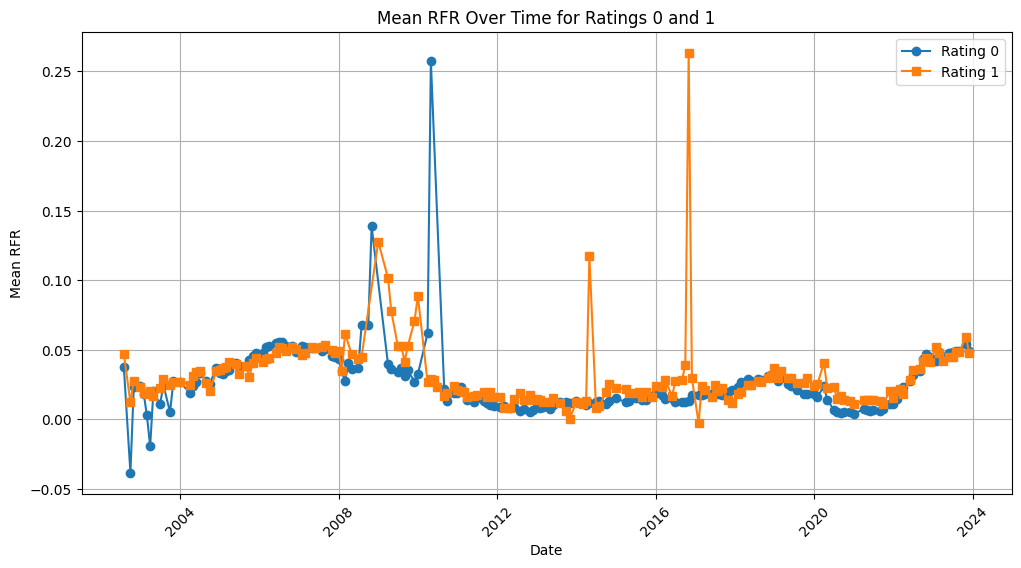

In [56]:
plt.figure(figsize=(12, 6))

# Plot for rating 0
df1_rating_0 = df1[df1['rating'] == 0]
plt.plot(df1_rating_0['date'], df1_rating_0['rfr'], label="Rating 0", linestyle='-', marker='o')

# Plot for rating 1
df1_rating_1 = df1[df1['rating'] == 1]
plt.plot(df1_rating_1['date'], df1_rating_1['rfr'], label="Rating 1", linestyle='-', marker='s')

# Formatting the plot
plt.xlabel("Date")
plt.ylabel("Mean RFR")
plt.title("Mean RFR Over Time for Ratings 0 and 1")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

# Show the plot
plt.show()